# Netflix Ratings: IMDB Score Predictors!

![Image of Netflix](https://help.nflxext.com/0af6ce3e-b27a-4722-a5f0-e32af4df3045_what_is_netflix_5_en.png)

## Looking at the 'Big Picture'...

### Frame the Problem

**What is the objective of this project?**

The objective for this project is to look at trends in the Netflix library of original content.

** How will the solution be used? **
The output of this project should be able to predict the IMDB Score of a particular Netflix title based on a variety of qualitative (Genre, Director, Language) and quantitative (Runtime, Days Since Premiere) features.

** How should the problem be framed? **
We should use a regression algorithm as we are looking to predict a continuous quantitative measure.

### Selecting a Performance Measure

** How should performance be measured? **
Performance will be measured using Root Mean Squared Error and Mean Absolute Error. 

$ RMSE(\textbf{X}, \textit{h}) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} ( h(\textbf{X}^{(i)}) - y^{(i)} )^{2} } $

$ MAE(\textbf{X}, \textit{h}) = \frac{1}{m} \sum_{i=1}^{m} | h(\textbf{X}^{(i)}) - y^{(i)} |  $

** Is the performance measure aligned with business objectives? **
The method of performance measurement should give *reasonable confidence* that the predictor is yielding results that give the best possible estimation based on the most impactful features.

### Other Discovery Questions

** What would be the minimum performance needed to reach the business objective? **

** What are comparable problems? Can you resuse experience or tools? **

** Is human expertise available? **

** How would you solve the problem manually? **

** List the assumptions made so far **

** Verify assumptions if possible **

Load initial packages and set parameters for matplotlib

In [412]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np #will need this to manipulate arrays
import pandas as pd #will need this to handle DataFrames and Series
import os #will help access file paths when retreiving data
import datetime #will help handle dates
from dateutil.relativedelta import relativedelta
from datetime import date

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Get the Data

** List the data you need and how much you need **

Will need data from Netflix at the grain of single movies/shows/programs.

** Find and document where you can get that data **

We can get the data from Kaggle. Here are some good candidates:

https://www.kaggle.com/luiscorter/netflix-original-films-imdb-scores *[Using this so far]*

https://www.kaggle.com/shivamb/netflix-shows *[TBD! Will use this in V2]*

**Other data questions to check**

Check how much space it will take.

Check legal obligations, and get authorization if necessary.

Get access authorizations.

Create workspace (with enough storage space).

**Get the data (forreal!)**

Ok - now let's get the data. In this case I've saved this file to my local computer. Depending on the volume of data, it might be smarter to only extract some of this data.

In [397]:
init_path = '/Users/blakenicholson/documents/personal/coding/handson-ml'

# /Users/blakenicholson/Documents/Personal/Coding/handson-ml/datasets/NetflixOriginals.csv

HOUSING_PATH = os.path.join(init_path,"datasets")


def load_netflixorigs_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "NetflixOriginals.csv")
    return pd.read_csv(csv_path, encoding = "latin-1")

netflix_data = load_netflixorigs_data()


** Check how much space it will take **

In [395]:
netflix_data.shape

(584, 8)

## Checking out the data structure

Ideally before jumping into this step, we'd have asked the experts about the data.

- Create a copy of the data for exploration.

- Create a Jupyter Notebook to keep a record of your data exploration.

- Study each attribute and its characterisitics:
    - Name
    - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    - % of missing values
    - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
    - Possibly useful for the task
    - Types of distribution (Gaussian, uniform, logarithmic, etc.)

- For supervised learning tasks, identify the target attribute(s).
    - Visualize the data
    - Study the correlation between attributes.
    - Study how you would solve the problem manually.
    - Identfiy the promising transformations you may want to apply.
    - Identify extra data that would be useful.
    - Document what you learn.

**Prepare the Data**

Notes:

- Work on copies of the data (keep the original dataset intact)

- Write functions for all data transformations you apply, for five reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects.
    - To clean and prepare the test set.
    - To clean and prepare new data instances once your solution is live.
    - To make it easy to treat your preparation choices as hyperparameters.

1. Data cleaning:
    - Fix or remove outliers (optional).
    - Fill in missing values (e.g., with zero, mean, median,...) or drop their rows (or columns)

2. Feature selection (optional):
    - Drop the attributes that provide no useful information for the task.

3. Feature Engineering, where appropriate:
    - Discretize continuous features.
    - Decompose features (e.g., categorical, date/time, etc.).
    - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.)
    - Aggregate features into promising new features.

4. Feature scaling: standardize or normalize features.

Check out the first few rows in the dataframe

In [155]:
netflix_data.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language
0,Enter the Anime,Documentary,8/5/19,58,2.5,English/Japanese
1,Dark Forces,Thriller,8/21/20,81,2.6,Spanish
2,The App,Science fiction/Drama,12/26/19,79,2.6,Italian
3,The Open House,Horror thriller,1/19/18,94,3.2,English
4,Kaali Khuhi,Mystery,10/30/20,90,3.4,Hindi


Look at the descriptive statistics of the dataframe

In [156]:
netflix_data.describe()

,Runtime,IMDB Score
count,584.000000,584.000000
mean,93.577055,6.271747
std,27.761683,0.979256
min,4.000000,2.500000
25%,86.000000,5.700000
50%,97.000000,6.350000
75%,108.000000,7.000000
max,209.000000,9.000000


In [421]:
print('Mean of Runtime: {0}'.format(np.mean(netflix_data['Runtime'])))

Mean of Runtime: 93.57705479452055


The first thing we notice is that we only have two continuous measures (*Runtime* and *IMDB Score*), so we may need to create more features to work with.

In [400]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 6 columns):
Title         584 non-null object
Genre         584 non-null object
Premiere      584 non-null object
Runtime       584 non-null int64
IMDB Score    584 non-null float64
Language      584 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 27.5+ KB


We are going to create another continuous feature that looks at the number of days between the Premiere date and today's date. We will create the 'days_since_premiere' column and add it back into our dataframe.

In [401]:
date1 = netflix_data["Premiere"]
date2 = pd.Series(data=date.today(), index=np.arange(len(date1)), name="Today").values.astype('datetime64[D]')
date1 = pd.to_datetime(date1).values.astype('datetime64[D]')
date_df = pd.DataFrame(dict(Start_date = date1, End_date = date2))
date_df['diff_days'] = date_df['End_date'] - date_df['Start_date']
date_df['diff_days'] = date_df['diff_days'] / np.timedelta64(1,'D')
netflix_data['days_since_premiere'] = date_df['diff_days']
netflix_data.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language,days_since_premiere
0,Enter the Anime,Documentary,8/5/19,58,2.5,English/Japanese,687.0
1,Dark Forces,Thriller,8/21/20,81,2.6,Spanish,305.0
2,The App,Science fiction/Drama,12/26/19,79,2.6,Italian,544.0
3,The Open House,Horror thriller,1/19/18,94,3.2,English,1250.0
4,Kaali Khuhi,Mystery,10/30/20,90,3.4,Hindi,235.0


Let's now look at some histograms of each measure to see what our distributions look like. IMDB Score and Runtime both seem to follow a normal distribution but days_since_premiere seems to follow a negative linear trend (which makes sense as more time goes by and the oldest movies continue to get older).

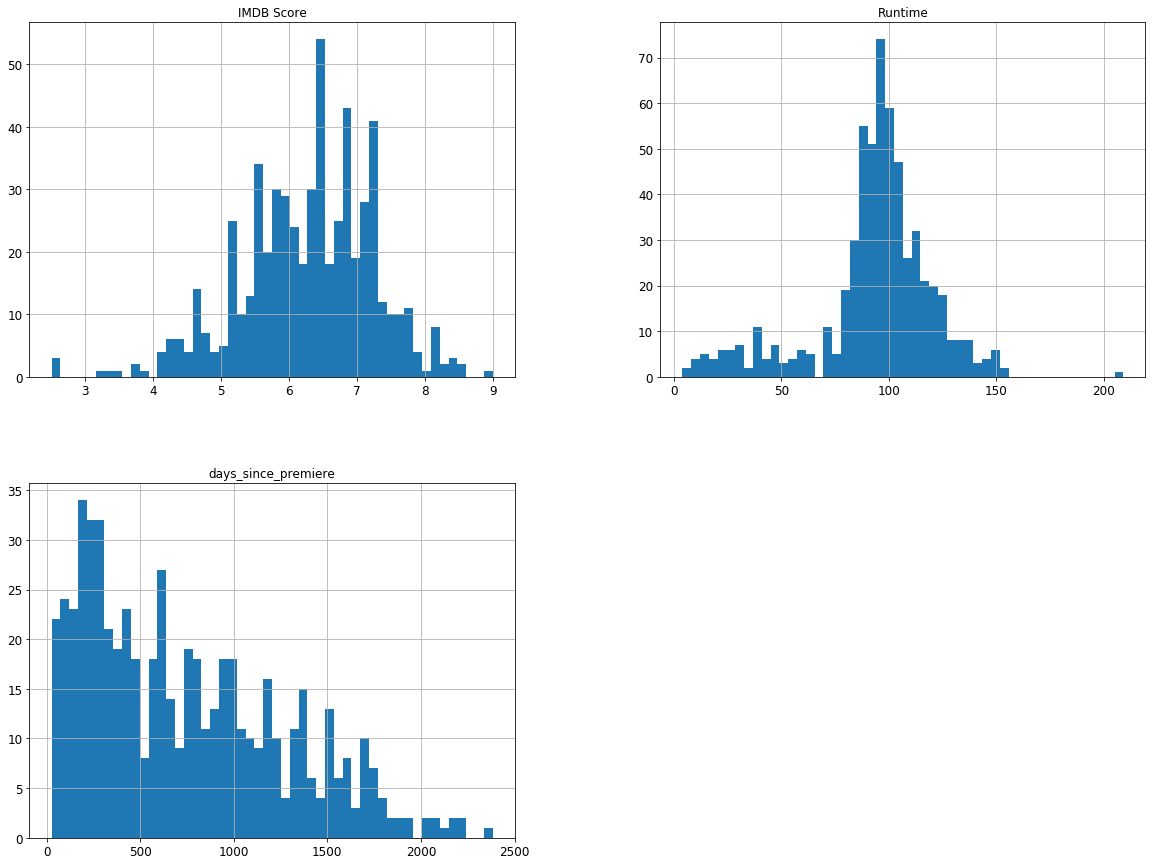

In [404]:
%matplotlib inline
import matplotlib.pyplot as plt
netflix_data.hist(bins=50, figsize=(20,15))
# save_fig("melb_attribute_histogram_plots")
plt.show()

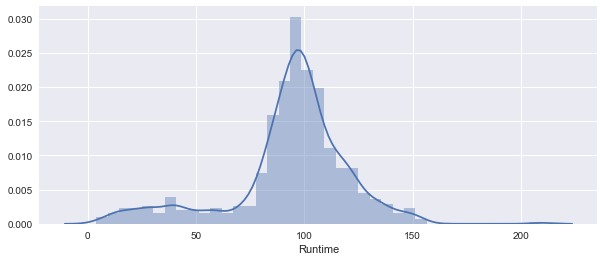

In [411]:
# netflix_data["Runtime"].hist(bins=100)

fig, ax = plt.subplots(1,1,figsize=(10, 4))

sns.distplot(netflix_data['Runtime'])

In [406]:
netflix_data.corr()

,Runtime,IMDB Score,days_since_premiere
Runtime,1.000000,-0.040896,-0.063521
IMDB Score,-0.040896,1.000000,0.122174
days_since_premiere,-0.063521,0.122174,1.000000


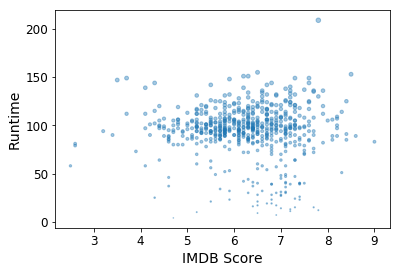

In [407]:
netflix_data.plot(kind="scatter", x="IMDB Score", y="Runtime", alpha=0.4, s=netflix_data["Runtime"]/10)

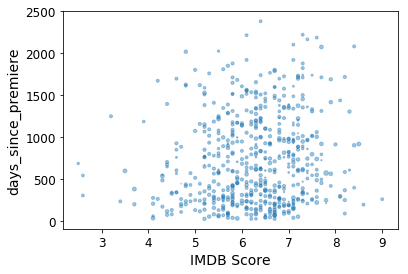

In [408]:
netflix_data.plot(kind="scatter", x="IMDB Score", y="days_since_premiere", alpha=0.4, s=netflix_data["Runtime"]/10)

## Create a Test Set

In [294]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(netflix_data, test_size=0.2, random_state=42)

In [295]:
train_set, test_set = split_train_test(netflix_data, 0.2)
print(len(train_set), "train +", len(test_set), "test")

468 train + 116 test


In [296]:
test_set.head()
test_set.shape

(116, 8)

In [297]:
train_set.head()
train_set.shape

(468, 8)

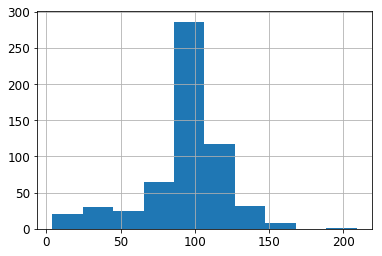

In [298]:
netflix_data["Runtime"].hist()

In [299]:
netflix_data["runtime_cat"] = np.ceil(netflix_data["Runtime"] / 20)
netflix_data["runtime_cat"].where(netflix_data["runtime_cat"] < 7, 7, inplace=True)
# netflix_data["runtime_cat"].where(netflix_data["runtime_cat"] < 7, 7, inplace=True)

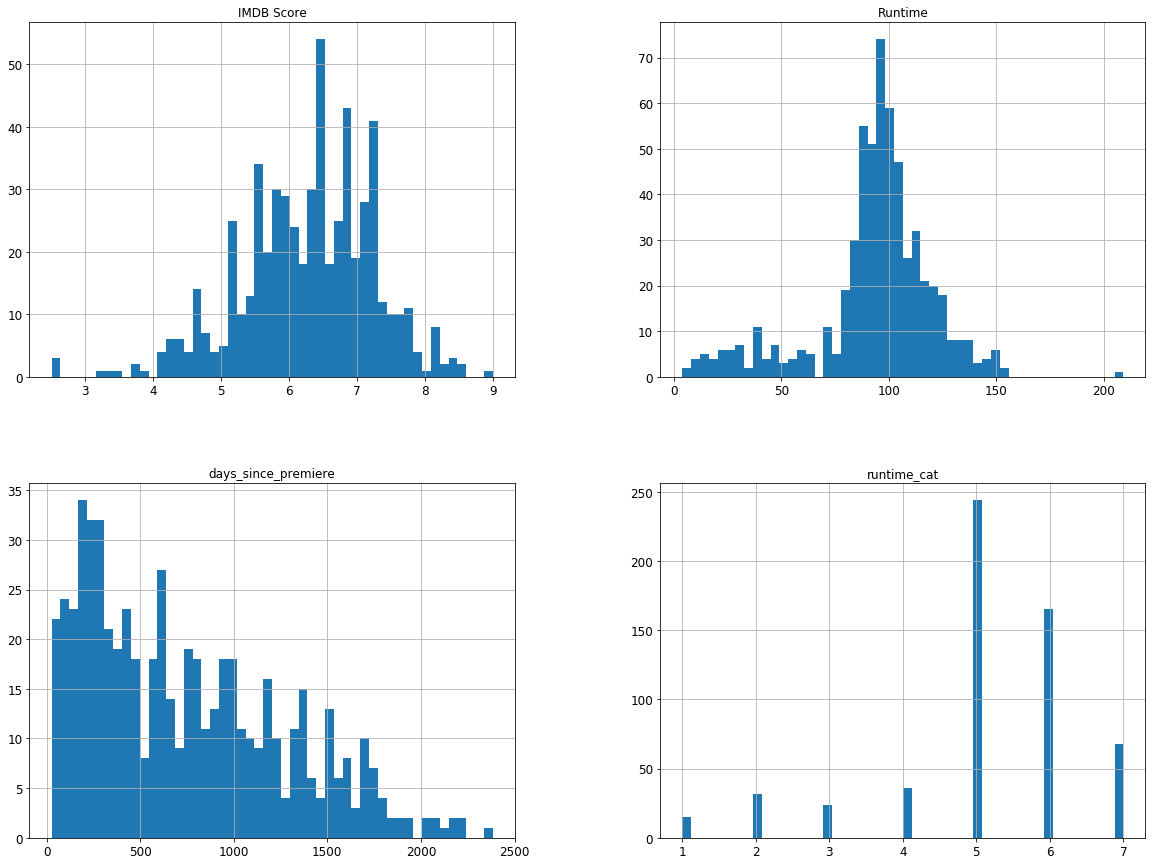

In [300]:
netflix_data.hist(bins=50, figsize=(20,15))
# save_fig("melb_attribute_histogram_plots")
plt.show()

In [301]:
y = netflix_data["Runtime"]
y.head()

0    58
1    81
2    79
3    94
4    90
Name: Runtime, dtype: int64

In [302]:
X = netflix_data.loc[:,['IMDB Score','Runtime']]
X.head()

,IMDB Score,Runtime
0,2.5,58
1,2.6,81
2,2.6,79
3,3.2,94
4,3.4,90


In [303]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.10,random_state=42)

# netflix_data.iloc[0:,1]
for train_index, test_index in split.split(netflix_data, netflix_data["runtime_cat"]):
    strat_train_set = netflix_data.loc[train_index]
    strat_test_set = netflix_data.loc[test_index]

In [304]:
print(split)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.1,
            train_size=None)


In [305]:
type(split)

sklearn.model_selection._split.StratifiedShuffleSplit

In [306]:
strat_test_set["runtime_cat"].value_counts() / len(strat_test_set)

5.0    0.423729
6.0    0.288136
7.0    0.118644
4.0    0.067797
2.0    0.050847
3.0    0.033898
1.0    0.016949
Name: runtime_cat, dtype: float64

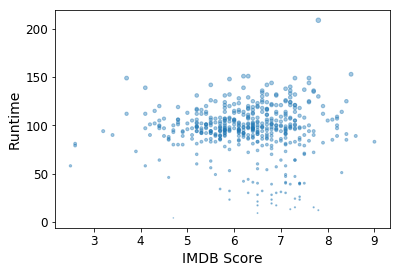

In [307]:
train_set.plot(kind="scatter", x="IMDB Score", y="Runtime", alpha=0.4, s=train_set["Runtime"]/10)

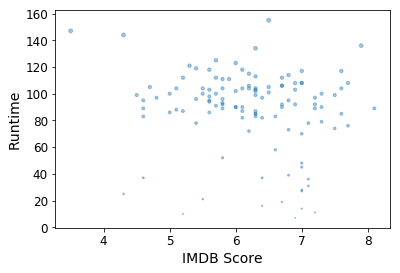

In [308]:
test_set.plot(kind="scatter", x="IMDB Score", y="Runtime", alpha=0.4, s=test_set["Runtime"]/10)

In [311]:
def genre_proportions(data):
    return data["Genre"].value_counts() / len(data)

def language_proportions(data):
    return data["Language"].value_counts() / len(data)

train_set, test_set = train_test_split(netflix_data, test_size=0.2, random_state=42)

# compare_props = pd.DataFrame({
#     "Overall": genre_proportions(netflix_data),
#     "Stratified": genre_proportions(strat_test_set),
#     "Random": genre_proportions(test_set),
# }).sort_index()

compare_props = pd.DataFrame({
    "Overall": language_proportions(netflix_data),
    "Stratified": language_proportions(strat_test_set),
    "Random": language_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [312]:
compare_props.sort_values(by="Overall", ascending=False)

,Overall,Random,Stratified,Rand. %error,Strat. %error
English,0.686644,0.675214,0.728814,-1.664642,6.141426
Hindi,0.056507,0.059829,0.050847,5.879306,-10.015408
Spanish,0.053082,0.051282,0.101695,-3.391232,91.580098
French,0.034247,0.017094,0.016949,-50.085470,-50.508475
Italian,0.023973,0.051282,0.016949,113.919414,-29.297821
Portuguese,0.020548,0.025641,NaN,24.786325,NaN
Indonesian,0.015411,0.025641,0.016949,66.381766,9.981168
Korean,0.010274,0.008547,NaN,-16.809117,NaN
Japanese,0.010274,NaN,NaN,NaN,NaN
German,0.008562,NaN,0.016949,NaN,97.966102


# Discover and visualize the data to gain insights

In [313]:
netflix = test_set.copy()
netflix.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language,runtime_cat,days_since_premiere
383,Paper Lives,Drama,3/12/21,97,6.7,Turkish,5.0,102.0
422,Outlaw King,Historical-epic,11/9/18,121,6.9,English,7.0,956.0
90,Things Heard & Seen,Horror,4/29/21,121,5.3,English,7.0,54.0
472,ReMastered: Tricky Dick & the Man in Black,Documentary,11/2/18,58,7.1,English,3.0,963.0
522,Long Shot,Documentary,9/29/17,40,7.4,English,2.0,1362.0


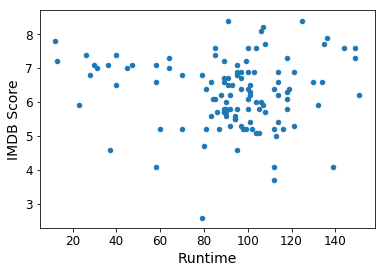

In [314]:
netflix.plot(kind="scatter", x="Runtime", y="IMDB Score")

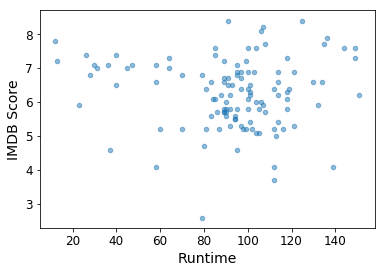

In [315]:
netflix.plot(kind="scatter", x="Runtime", y="IMDB Score", alpha=0.5)

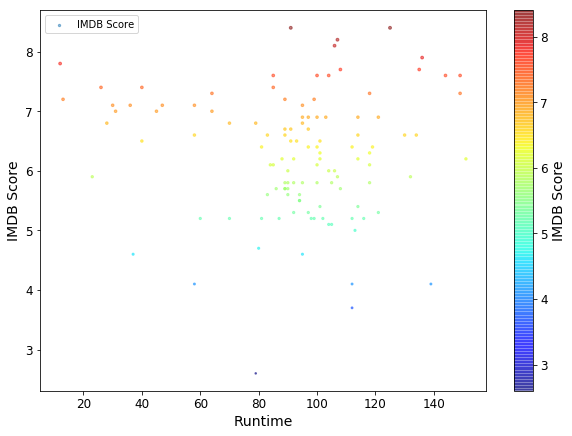

In [316]:
netflix.plot(kind="scatter", x="Runtime", y="IMDB Score", alpha=0.5,
    s=netflix["IMDB Score"], label="IMDB Score", figsize=(10,7),
    c="IMDB Score", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [317]:
corr_matrix = netflix.corr()

In [318]:
corr_matrix["IMDB Score"].sort_values(ascending=False)

IMDB Score             1.000000
days_since_premiere    0.079922
runtime_cat           -0.051355
Runtime               -0.056810
Name: IMDB Score, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fec8d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120770f60>]], dtype=object)

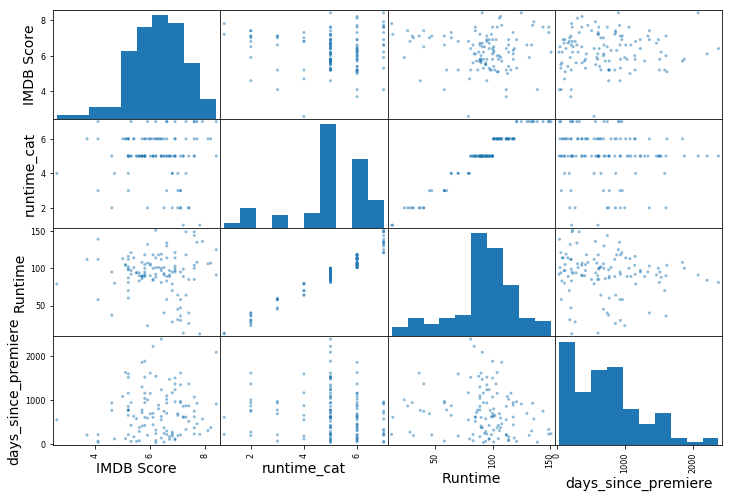

In [320]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["IMDB Score", "runtime_cat", "Runtime","days_since_premiere"]
scatter_matrix(netflix[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

Saving figure rooms_vs_house_value_scatterplot


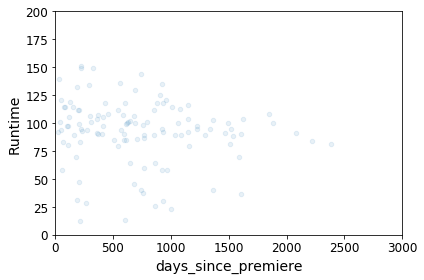

In [326]:
netflix.plot(kind="scatter", x="days_since_premiere", y="Runtime",
             alpha=0.1)
plt.axis([0, 3000, 0, 200])
save_fig("rooms_vs_house_value_scatterplot")

# Prepare the data for Machine Learning Algorithms

In [327]:
netflix = strat_train_set.drop("Runtime", axis=1) # drop labels for training set
netflix_labels = strat_train_set["Runtime"].copy()

In [328]:
sample_incomplete_rows = netflix[netflix.isnull().any(axis=1)].head()
sample_incomplete_rows

,Title,Genre,Premiere,IMDB Score,Language,runtime_cat,days_since_premiere


In [329]:
median = netflix["IMDB Score"].median()
sample_incomplete_rows["IMDB Score"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,Title,Genre,Premiere,IMDB Score,Language,runtime_cat,days_since_premiere


In [330]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [331]:
# housing_num = housing.drop('ocean_proximity', axis=1)
netflix_num = netflix.select_dtypes(include=[np.number])
netflix_num.head()

,IMDB Score,runtime_cat,days_since_premiere
322,6.5,5.0,298.0
245,6.2,5.0,27.0
404,6.8,4.0,1309.0
91,5.3,5.0,1094.0
286,6.3,5.0,816.0


In [332]:
imputer.fit(netflix_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [333]:
imputer.statistics_

array([   6.3,    5. ,  608. ])

In [334]:
netflix_num.median().values

array([   6.3,    5. ,  608. ])

In [335]:
X = imputer.transform(netflix_num)

In [336]:
netflix_tr = pd.DataFrame(X, columns=netflix_num.columns,
                          index = list(netflix.index.values))

In [337]:
netflix_tr.loc[sample_incomplete_rows.index.values]

,IMDB Score,runtime_cat,days_since_premiere


In [338]:
imputer.strategy

'median'

In [339]:
netflix_tr = pd.DataFrame(X, columns=netflix_num.columns)
netflix_tr.head()

,IMDB Score,runtime_cat,days_since_premiere
0,6.5,5.0,298.0
1,6.2,5.0,27.0
2,6.8,4.0,1309.0
3,5.3,5.0,1094.0
4,6.3,5.0,816.0


Now let's preprocess the categorical input feature, ocean_proximity:

In [340]:
# housing_cat = housing[['Suburb','Type','Method','SellerG','CouncilArea','Regionname']]
netflix_cat = netflix['Genre']
netflix_cat.head()

322              Drama
245             Biopic
404        Documentary
91     Romantic comedy
286        Documentary
Name: Genre, dtype: object

In [341]:
from future_encoders import OrdinalEncoder

In [342]:
netflix_cat.describe()

count             525
unique            109
top       Documentary
freq              141
Name: Genre, dtype: object

In [344]:
ordinal_encoder = OrdinalEncoder()
netflix_cat_encoded = ordinal_encoder.fit_transform(netflix_cat.values.reshape(1,-1))
netflix_cat_encoded[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [345]:
ordinal_encoder.categories_

[array(['Drama'], dtype=object),
 array(['Biopic'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Comedy'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Comedy'], dtype=object),
 array(['Horror'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Action comedy'], dtype=object),
 array(['Anime/Fantasy'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Satire'], dtype=object),
 array(['Thriller'], dtype=object),
 array(['Romantic drama'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Heist'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Action'], dtype=object),
 array(['Animation/Musical/Adventure'], dtype=o

In [346]:
from future_encoders import OneHotEncoder

cat_encoder = OneHotEncoder()
netflix_cat_1hot = cat_encoder.fit_transform(netflix_cat)
netflix_cat_1hot

/Users/blakenicholson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/blakenicholson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


<1x525 sparse matrix of type '<class 'numpy.float64'>'
	with 525 stored elements in Compressed Sparse Row format>

By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [347]:
netflix_cat_1hot.toarray()

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [348]:
cat_encoder = OneHotEncoder(sparse=False)
netflix_cat_1hot = cat_encoder.fit_transform(netflix_cat)
netflix_cat_1hot

/Users/blakenicholson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/blakenicholson/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

In [349]:
cat_encoder.categories_

[array(['Drama'], dtype=object),
 array(['Biopic'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Comedy'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Comedy'], dtype=object),
 array(['Horror'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Action comedy'], dtype=object),
 array(['Anime/Fantasy'], dtype=object),
 array(['Documentary'], dtype=object),
 array(['Satire'], dtype=object),
 array(['Thriller'], dtype=object),
 array(['Romantic drama'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Heist'], dtype=object),
 array(['Romantic comedy'], dtype=object),
 array(['Action'], dtype=object),
 array(['Animation/Musical/Adventure'], dtype=o

Let's create a custom transformer to add extra attributes:

"IMDB Score", "runtime_cat", "Runtime","days_since_premiere"

In [117]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
imdb_ix, runtime_ix, days_since_premiere_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_days_since_premiere = True): # no *args or **kargs
        self.add_days_since_premiere = add_days_since_premiere
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        days_since_premiere = X[:, rooms_ix] / X[:, household_ix]
            date1 = netflix_data["Premiere"]
            date2 = pd.Series(data=date.today(), index=np.arange(len(date1)), name="Today").values.astype('datetime64[D]')
            date1 = pd.to_datetime(date1).values.astype('datetime64[D]')
            date_df = pd.DataFrame(dict(Start_date = date1, End_date = date2))
            date_df['diff_days'] = date_df['End_date'] - date_df['Start_date']
            date_df['diff_days'] = date_df['diff_days'] / np.timedelta64(1,'D')
            netflix_data['days_since_premiere'] = date_df['diff_days']
            netflix_data.head()
        
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

Now let's build a pipeline for preprocessing the numerical attributes:

In [351]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
#         ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

netflix_num_tr = num_pipeline.fit_transform(netflix_num)

In [353]:
netflix_num_tr

array([[ 0.23757285, -0.07066831, -0.81105452],
       [-0.06812751, -0.07066831, -1.32626297],
       [ 0.54327321, -0.79813616,  1.11099618],
       ..., 
       [ 0.54327321, -0.07066831, -0.95744216],
       [ 0.33947297, -0.07066831, -1.29014134],
       [-0.27192775,  0.65679955,  0.79920952]])

In [354]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [355]:
num_attribs = list(netflix_num)
cat_attribs = ["Genre"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
#         ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [362]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [363]:
netflix_prepared = full_pipeline.fit_transform(netflix)
netflix_prepared

array([[ 0.23757285, -0.07066831, -0.81105452, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06812751, -0.07066831, -1.32626297, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54327321, -0.79813616,  1.11099618, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.54327321, -0.07066831, -0.95744216, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33947297, -0.07066831, -1.29014134, ...,  0.        ,
         0.        ,  0.        ],
       [-0.27192775,  0.65679955,  0.79920952, ...,  0.        ,
         0.        ,  0.        ]])

In [364]:
netflix_prepared.shape

(525, 112)

In [366]:
netflix_labels.shape

(525,)

# Select and train a model

In [367]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(netflix_prepared, netflix_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [368]:
# let's try the full pipeline on a few training instances
some_data = netflix.iloc[:5]
some_labels = netflix_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 92.86621094  93.49554443  72.27642822  91.05474854  91.13824463]


Compare against the actual values:

In [369]:
print("Labels:", list(some_labels))

Labels: [93, 92, 73, 95, 87]


In [276]:
some_data_prepared

array([[ -9.72795264e-01,  -1.44425968e+00,  -5.75961896e-01,
         -9.35293152e-01,  -6.28794433e-01,   6.59078196e-01,
         -3.45319883e-02,   1.10124785e-01,   1.02618027e-01,
         -2.78517159e-01,  -1.53807139e-01,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  2.14351526e+00,  -2.02908792e-01,  -9.83697971e-01,
          2.13852700e+00,   3.55572178e+00,   2.50262065e-02,
         -3.45319883e-02,   1.10124785e-01,  -5.94390820e-01,
         -1.05651588e+00,  -1.52762625e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00],
       [  2.14351526e+00,   2.22211377e-01,   6.36226434e-01,
          2.13852700e+00,  -6.28794433e-01,  -1.23228360e-03,
         -3.45319883e-02,  -1.24591008e+00,  -1.09414730e+00,
          5.2040

In [372]:
from sklearn.metrics import mean_squared_error

netflix_predictions = lin_reg.predict(netflix_prepared)
lin_mse = mean_squared_error(netflix_labels, netflix_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.2911016181134816

In [373]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(netflix_labels, netflix_predictions)
lin_mae

4.38238525390625

In [374]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(netflix_prepared, netflix_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [375]:
netflix_predictions = tree_reg.predict(netflix_prepared)
tree_mse = mean_squared_error(netflix_labels, netflix_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [376]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, netflix_prepared, netflix_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [377]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [  8.30207976  10.56248256  20.68998482   8.93266214   9.35565614
  14.17812508   9.46654027   8.90656629  15.1632146    7.0492771 ]
Mean: 11.2606588747
Standard deviation: 3.96786255579


In [378]:
lin_scores = cross_val_score(lin_reg, netflix_prepared, netflix_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  4.90651970e+12   8.30133830e+11   1.37448048e+14   8.88514328e+13
   3.00655181e+12   5.28139699e+12   2.68376723e+12   1.09539881e+13
   1.25702016e+01   1.20283513e+13]
Mean: 2.65990189541e+13
Standard deviation: 4.47716809089e+13


In [379]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(netflix_prepared, netflix_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [380]:
netflix_predictions = forest_reg.predict(netflix_prepared)
forest_mse = mean_squared_error(netflix_labels, netflix_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.4262488164727545

In [381]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, netflix_prepared, netflix_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [  5.83724218   8.294895    10.21765029   6.29231337   7.31069261
   8.14138289   6.20317847   7.37219308  12.23631889   6.87520629]
Mean: 7.87810730539
Standard deviation: 1.8915463035


In [382]:
scores = cross_val_score(lin_reg, netflix_prepared, netflix_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    1.000000e+01
mean     2.659902e+13
std      4.719350e+13
min      1.257020e+01
25%      2.764463e+12
50%      5.093958e+12
75%      1.175976e+13
max      1.374480e+14
dtype: float64

In [385]:
from sklearn.svm import SVR

svm_reg_rbf = SVR(kernel="rbf")
svm_reg_rbf.fit(netflix_prepared, netflix_labels)
netflix_predictions = svm_reg_rbf.predict(netflix_prepared)
svm_mse = mean_squared_error(netflix_labels, netflix_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

22.713482038586957

In [386]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(netflix_prepared, netflix_labels)
housing_predictions = svm_reg.predict(netflix_prepared)
svm_mse = mean_squared_error(netflix_labels, netflix_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

22.713482038586957

In [387]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(netflix_prepared, netflix_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [388]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [389]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [390]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

12.8642402515 {'max_features': 2, 'n_estimators': 3}
11.7774586959 {'max_features': 2, 'n_estimators': 10}
11.0366914757 {'max_features': 2, 'n_estimators': 30}
13.6229265205 {'max_features': 4, 'n_estimators': 3}
11.7602348535 {'max_features': 4, 'n_estimators': 10}
10.9540728576 {'max_features': 4, 'n_estimators': 30}
13.0179282156 {'max_features': 6, 'n_estimators': 3}
10.1604302496 {'max_features': 6, 'n_estimators': 10}
10.3482936252 {'max_features': 6, 'n_estimators': 30}
13.7003147533 {'max_features': 8, 'n_estimators': 3}
10.3734340184 {'max_features': 8, 'n_estimators': 10}
10.0598383233 {'max_features': 8, 'n_estimators': 30}
13.2233559605 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
11.704691774 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
12.6204587411 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
11.6490596391 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
12.4238037441 {'bootstrap': False, 'max_features': 4, 'n_estima

In [391]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.020032,0.005267,-165.488677,-48.685132,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",14,-158.307937,...,-268.118519,-70.120370,-83.291005,-28.671429,-197.367196,-52.887566,0.006234,0.004320,63.865259,13.951797
1,0.062914,0.002252,-138.708533,-27.312090,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-116.974571,...,-160.853524,-27.657571,-98.607143,-23.953095,-214.894190,-39.400571,0.024604,0.000866,44.061430,6.326613
2,0.107841,0.009594,-121.808559,-20.887763,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",6,-109.244032,...,-125.837471,-21.033648,-94.468317,-19.166693,-193.415492,-24.539569,0.057244,0.009066,38.277542,2.760932
3,0.005902,0.000907,-185.584127,-47.411005,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",17,-189.403175,...,-154.000000,-37.028042,-235.536508,-67.166667,-192.111111,-38.052381,0.000416,0.000181,29.578689,10.823065
4,0.016647,0.001389,-138.303124,-23.177224,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",10,-110.430857,...,-138.687143,-21.135333,-159.261714,-31.835214,-166.381429,-19.184286,0.001711,0.000251,22.221650,4.676912
5,0.048180,0.002811,-119.991712,-17.081020,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",5,-97.365873,...,-132.371831,-17.742460,-108.662624,-18.226392,-170.783397,-16.047788,0.004513,0.000275,29.075644,0.937185
6,0.006142,0.000893,-169.466455,-44.331005,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",15,-134.499471,...,-142.058201,-40.340476,-187.408466,-40.552381,-168.707937,-41.670370,0.000379,0.000130,29.457384,4.290982
7,0.016930,0.001375,-103.234343,-21.052719,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",2,-77.970095,...,-84.213714,-16.480024,-100.316571,-21.085976,-134.815810,-21.469310,0.001061,0.000139,21.213157,2.466746
8,0.047647,0.002708,-107.087181,-16.421818,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",3,-98.074730,...,-95.129175,-14.577566,-92.963302,-17.934757,-153.179968,-14.270111,0.001568,0.000066,23.105035,1.801572
9,0.005588,0.000798,-187.698624,-44.825185,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",18,-116.178836,...,-164.092063,-45.569841,-229.304762,-56.276455,-200.060317,-42.585714,0.000310,0.000149,43.012221,7.869865


In [393]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Runtime", axis=1)
y_test = strat_test_set["Runtime"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

ValueError: Found unknown categories ['Anthology/Dark comedy' 'Christmas musical' 'Coming-of-age comedy-drama'
 'Science fiction adventure' 'Science fiction/Mystery' 'Supernatural drama'] in column 0 during transform

In [297]:
final_rmse

291796.92019370466

In [298]:
from scipy import stats

In [299]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([ 270738.74495847,  311434.45096421])

In [301]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(270738.74495846959, 311434.45096420537)

Alternatively, we could use a z-scores rather than t-scores:

In [302]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(270748.49767663126, 311425.97238334263)

#  ----

NameError: name 'save_fig' is not defined

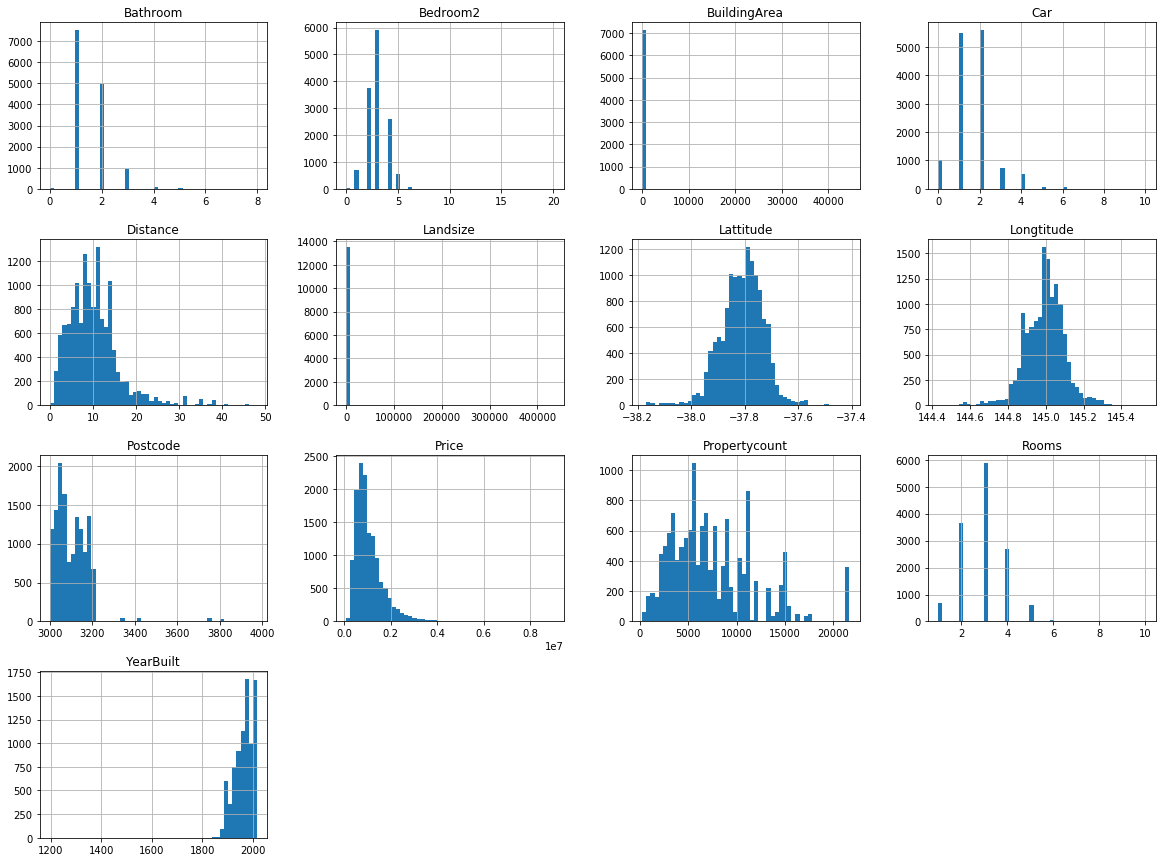

In [4]:
# create a pipeline objectb
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# fit the whole pipeline
pipe.fit(X_train, y_train)

score = accuracy_score(pipe.predict(X_test), y_test)

print(score)